https://medium.com/analytics-vidhya/an-analysis-of-normalized-cuts-and-image-segmentation-1acb05d1a2e9 -> pojašnjen rad
https://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/Normalized%20Graph%20cuts.pdf -> prezentacija o radu
https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf -> rad

spectral clustering: https://arxiv.org/pdf/0711.0189

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

In [2]:

class SpectralClusteringSM:
    def __init__(self, sigma_I, sigma_X, r, lanczos_k, l, ncut_max):
        self.sigma_I = sigma_I #intsnsitiy scale
        self.sigma_X = sigma_X #spatial sclae
        self.r = r # spatial cutoff
        self.lanczos_k = lanczos_k
        self.l = l
        self.ncut_max = ncut_max  # threshold za splitting
        self.current_cluster_id = 0
        #self.max_clusters = max_clusters

    #-----------------------učitavanje slike-----------------------------
    def load_image(self, image_path):
        self.img = io.imread(image_path, as_gray=True).astype(np.float64)
        # skaliranje brigthnessa na 0-255
        self.img *= 255  
        self.img = np.clip(self.img, 0, 255)
        self.rows, self.cols = self.img.shape
        #------------------pretvaranje pixela u čvorove------------------
        self.X = np.array([(i, j) for i in range(self.rows) for j in range(self.cols)])
        self.intensities = self.img.flatten()
        self.n = self.X.shape[0]
        self.clusters = np.zeros(self.n, dtype=int) # ???
        return self
    
    """ 1.KORAK """
    #---------------------- iz rada SM formula za simm.----------------------
    def compute_similarity_matrix(self):
        W = np.zeros((self.n, self.n))  # simmilarity matrix prema brightness
        r_sq = self.r ** 2
        for i in range(self.n):
                for j in range(i + 1, self.n):
                    spatial_dist_sq = np.linalg.norm(self.X[i] - self.X[j])
                    if spatial_dist_sq < r_sq:
                        intensity_diff_sq = np.linalg.norm(self.intensities[i] - self.intensities[j]) ** 2
                        w_ij = np.exp(-intensity_diff_sq / (self.sigma_I ** 2)) * \
                            np.exp(-spatial_dist_sq**2 / (self.sigma_X ** 2))
                        W[i, j] = w_ij
                        W[j, i] = w_ij

            
        self.W = W
        return self

    """ 2.KORAK """
    #---------------------- eigenvrijednosti - eigenvektori ----------------
    def compute_laplacian(self, W=None):
        #L = D - W -> nenormalizirana matrica
        if W is None:
            W = self.W
        D = np.diag(np.sum(W, axis=1))
        # PROBLEM: nekad naiđe na dijeljenje s 0
        # 
        D_inv_sqrt = np.diag([1.0 / np.sqrt(d) if d != 0 else 0 for d in np.diag(D)]) # D^1/2
        return D_inv_sqrt @ (D - W) @ D_inv_sqrt

    # koristimo Lanczovou metodu da kretiramo manju matricu T umjesto L za 
    # izračunavanje eigen... built-in metodom .eigh
    # https://arxiv.org/pdf/2410.11090
    def lanczos(self, A, b):
        Q = np.zeros((len(b), self.lanczos_k))
        alphas = np.zeros(self.lanczos_k)
        betas = np.zeros(self.lanczos_k-1)
        
        q_prev = np.zeros(len(b)) # q_-1
        q_curr = b / np.sqrt(np.sum(b**2)) # q_0
        beta_prev = 0.0 # beta_-1
        
        #for 𝑛 = 0, 1, … , 𝑘 − 1 do...
        for i in range(self.lanczos_k):
            Q[:, i] = q_curr
            
            # korak 4: 𝐲𝑛+1 = 𝐀𝐪𝑛 − 𝛽𝑛−1𝐪𝑛−1
            # TODO: callable???
            if callable(A):
                y = A*q_curr - beta_prev * q_prev
            else:
                y = A @ q_curr - beta_prev * q_prev
            
            # korak 5: 𝛼𝑛 = 𝐪⊺𝑛*𝐲𝑛+1
            alpha_i = q_curr.T @ y
            alphas[i] = alpha_i
            
            # korak 6: 𝐳𝑛+1 = 𝐲𝑛+1 − 𝛼𝑛𝐪𝑛
            z = y - alpha_i * q_curr
            
            #korak 7: preskok
            
           
            if i < self.lanczos_k - 1:
                 # korak 8: 𝛽𝑛 = ‖𝐳𝑛+1‖2


                beta_i = np.sqrt(np.sum(z**2))
                betas[i] = beta_i
                
                # korak 9: 𝐪𝑛+1 = 𝐳𝑛+1/𝛽𝑛
                q_prev = q_curr
                q_curr = z / beta_i
                beta_prev = beta_i
        
        return Q, alphas, betas
    

    def compute_fiedler_vector(self, L):
        #b = np.random.rand(self.n)
        b = np.ones(L.shape[0]) # da maknemo randomness
        Q, alphas, betas = self.lanczos(L, b)
        # tridijagonalna matrica
        T = np.diag(alphas) + np.diag(betas, 1) + np.diag(betas, -1)
        # TODO: zamijeniti built-in .eigh funkciju ??
        eigvals, eigvecs = np.linalg.eigh(T)
        
        fiedler = Q @ eigvecs[:, 1]
        fiedler = np.sign(fiedler[np.argmax(np.abs(fiedler))]) * fiedler # consistent sign ??
        return fiedler

    """ 3.KORAK """
    #----------------------------- N-cut ----------------------------------
    # "Currently, the search is done by checking l evenly spaced possible 
    # splitting points, and computing the best Ncut among them.""
    #clusters = np.where(fiedler_vector >= 0, 1, 0)  # separacija prema predznaku
    def compute_ncut(self, W, D, A, B):
         # "Cut between A and B: sum of weights of edges between A and B"
        cut_AB = np.sum(W[A, :][:, B])
        assoc_A = np.sum(D[A])
        assoc_B = np.sum(D[B])
        return (cut_AB / assoc_A) + (cut_AB / assoc_B)

    
    
    def recursive_two_way(self, indices, parent_cluster_id=0):
        # logika da se i prati max broj grupa: or self.current_cluster_id >= self.max_clusters - 1
        if len(indices) < self.l :
            self.clusters[indices] = parent_cluster_id
            return

        # podgrafovi za trenutni cluser
        W_sub = self.W[indices][:, indices]
        L_sub = self.compute_laplacian(W_sub)
        fiedler = self.compute_fiedler_vector(L_sub)
        
        #------------------------ Find optimal split ----------------------------
        sorted_idx = np.argsort(fiedler)
        min_ncut = np.inf
        best_split = self.l
        ncut_values = []
        for i in range(self.l, len(fiedler) - self.l, self.l):
            A = sorted_idx[:i]
            B = sorted_idx[i:]
            current_ncut = self.compute_ncut(W_sub, np.diag(np.sum(W_sub, axis=1)), A, B)
            if current_ncut < min_ncut:
                min_ncut = current_ncut
                best_split = i
                ncut_values.append(current_ncut) 
        "4. KORAK "
        #----------------------------- cut - stability ----------------------------
        # kako odrediti max cut:
            # empririjski [0.1,0.5] ->provjeriti
            # malo iznad prosjeka
        #self.max_ncut = np.mean(ncut_values) # previše grupa
        
        # dijeliti ili ne
        # logika da se prati  i broj grupa: """ and self.current_cluster_id < self.max_clusters - 1 """
        if min_ncut < self.ncut_max:  
            left = indices[sorted_idx[:best_split]]
            right = indices[sorted_idx[best_split:]]
            
            "5. KORAK"
            #----------------------------- two-way recursion ----------------------------
            self.current_cluster_id += 1
            new_cluster_id = self.current_cluster_id
            
            self.clusters[right] = new_cluster_id
            self.recursive_two_way(left, parent_cluster_id)
            self.recursive_two_way(right, new_cluster_id)
        else:
            self.clusters[indices] = parent_cluster_id
            
       

    # pipline koji poziva sve bitne funkcije
    def segment_image(self):
        self.compute_similarity_matrix()
        self.recursive_two_way(np.arange(self.n))
        return self.clusters.reshape((self.rows, self.cols))
    
    #---------------------------------- average color ---------------------------------------
    def average_color(self):
        self.segmented_img = self.clusters.reshape((self.rows, self.cols))
        num_clusters = len(set(self.clusters))
        group_sums = np.zeros(num_clusters)
        group_counts = np.zeros(num_clusters)

        for i in range(self.segmented_img.shape[0]):
            for j in range(self.segmented_img.shape[1]):
                group_label = self.segmented_img[i, j]
                group_value = self.img[i, j]
                
                group_sums[group_label] += group_value
                group_counts[group_label] += 1

        group_averages = (group_sums / group_counts) / 255
        rgb_grouped = [(group_averages[i], group_averages[i], group_averages[i]) for i in range(0, len(group_averages))]
        cmap = mcolors.ListedColormap(rgb_grouped)
    
        return cmap
    

    def visualize(self):
        segmented_img = self.clusters.reshape((self.rows, self.cols))
        cmap_custom = self.average_color()
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(self.img, cmap='gray')
        axs[0].set_title('Original')
        axs[0].axis('off')
        
        axs[1].imshow(segmented_img, cmap=cmap_custom)
        axs[1].set_title('Spectralno Grupiranje: Ncut + Lanczos')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        

In [3]:
""" clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=20, 
                                 lanczos_k=5, l=3, ncut_max=0.3, max_clusters=3)
clusterer.load_image('image3.png')
segmented = clusterer.segment_image()
clusterer.visualize() """

" clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=20, \n                                 lanczos_k=5, l=3, ncut_max=0.3, max_clusters=3)\nclusterer.load_image('image3.png')\nsegmented = clusterer.segment_image()\nclusterer.visualize() "

LANCZOS k: broj iteracija za kreiranje reduciranje T matrice za eigenvektore
- što je veći k to je matrica biti bolja aproksimacija originalno Laplaciana
- manji k: manje precizne aproskimacije
- utječe na brzinu 
- k određuje koliko prvih k eigenvektora dobivamo

custom color


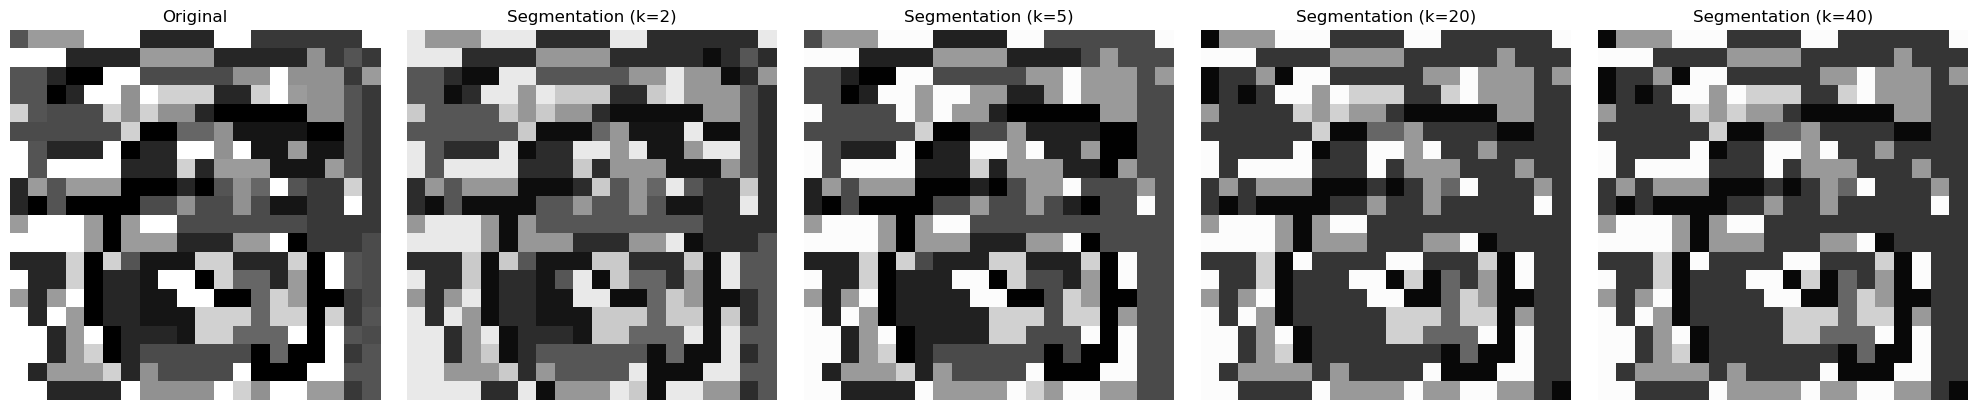

In [4]:
 # za različite k - koliko iteracija Lanczos ima - veći k, bolja aprox. T
k_values = [2,5,20,40]  
print('custom color')
fig, axs = plt.subplots(1, len(k_values) + 1, figsize=(20, 4))

clusterer = SpectralClusteringSM(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10, ncut_max=0.3)
clusterer.load_image('images/image3.png') 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

for idx, k in enumerate(k_values):
    clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=20, lanczos_k=k, l=10, ncut_max=0.9)
    clusterer.load_image('images/image3.png')
    segmented = clusterer.segment_image()

    cmap_custom = clusterer.average_color()
    axs[idx+1].imshow(segmented, cmap=cmap_custom)
    axs[idx+1].set_title(f'Segmentation (k={k})')
    axs[idx+1].axis('off')

plt.tight_layout()
plt.show()
    

custom color


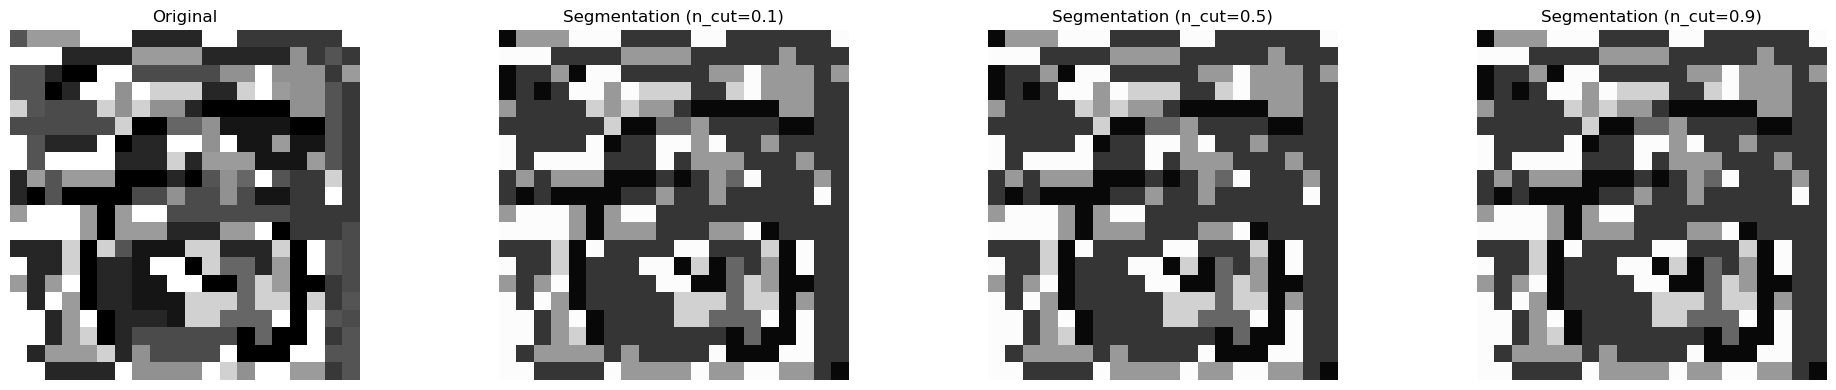

In [5]:
# za različite ncut_max -> kada stavim da je prosjek kod svakog dijeljenja, previše grupa
# n-cut je u [0.9,0.1]
print('custom color')
ncut_values = [0.1, 0.5, 0.9]  
fig, axs = plt.subplots(1, len(ncut_values) + 1, figsize=(20, 4))

clusterer = SpectralClusteringSM(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10, ncut_max=0.3)
clusterer.load_image('images/image3.png') 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

for idx, n in enumerate(ncut_values):
        clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=20, lanczos_k=30, l=10, ncut_max=0.9)
        clusterer.load_image('images/image3.png')
        segmented = clusterer.segment_image()

        cmap_custom = clusterer.average_color()
        axs[idx+1].imshow(segmented, cmap=cmap_custom)
        axs[idx+1].set_title(f'Segmentation (n_cut={n})')
        axs[idx+1].axis('off')

plt.tight_layout()
plt.show()

custom color


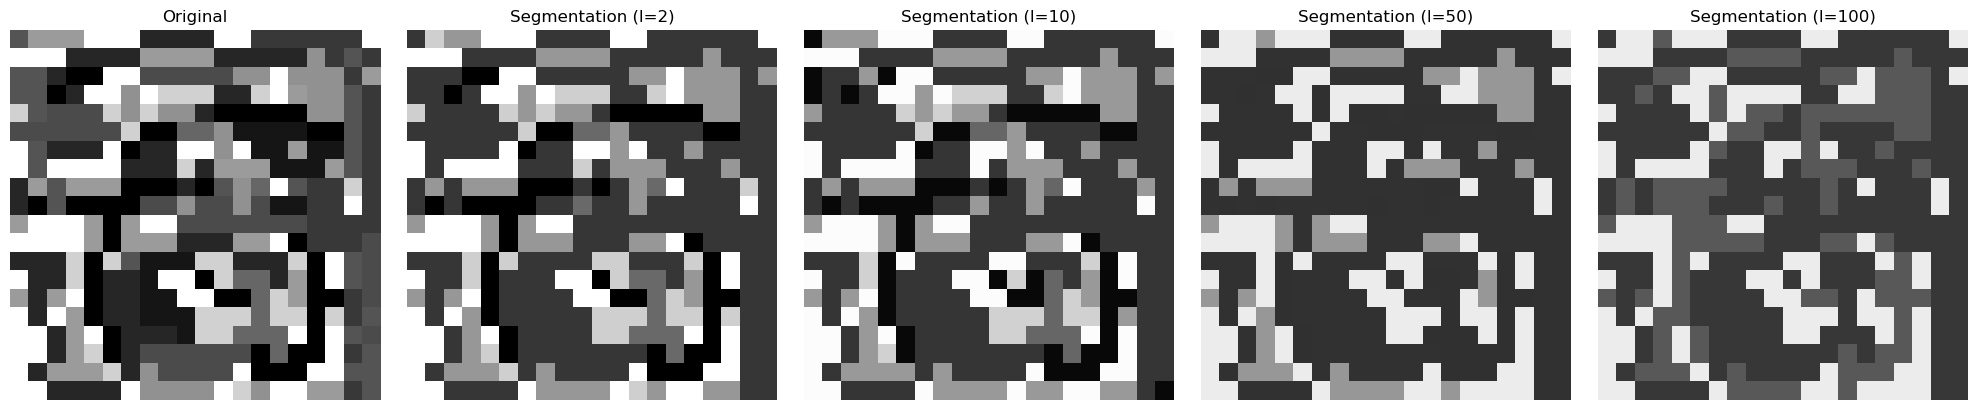

In [6]:
# različiti l 
#ncut i max_cluster su na maximumu da ne utječu na rezultate
l_values = [2,10,50,100]  
print('custom color')
fig, axs = plt.subplots(1, len(l_values) + 1, figsize=(20, 4))

clusterer = SpectralClusteringSM(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10, ncut_max=0.3)
clusterer.load_image('images/image3.png') 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

for idx, l in enumerate(l_values):
        clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=10, lanczos_k=30, l=l, ncut_max=0.9)
        clusterer.load_image('images/image3.png')
        segmented = clusterer.segment_image()

        cmap_custom = clusterer.average_color()
        axs[idx+1].imshow(segmented, cmap=cmap_custom)
        axs[idx+1].set_title(f'Segmentation (l={l})')
        axs[idx+1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Ncut je maximalan, tako da možemo upravljati brojem clustera, jer uvjet za grupiranje je ili dosegnut n-cut ili max_cluster
def visualize_line(image_name, values, custom):
    fig, axs = plt.subplots(1, len(values) + 1, figsize=(20, 4))

    clusterer = SpectralClusteringSM(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10, ncut_max=0.3)
    clusterer.load_image(image_name) 

    axs[0].imshow(clusterer.img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    for idx, n in enumerate(values):
        clusterer = SpectralClusteringSM(sigma_I=50, sigma_X=100, r=10, lanczos_k=10, l=10, ncut_max=n)
        clusterer.load_image(image_name)
        segmented = clusterer.segment_image()
        if custom == True:
            # ------------------------------------------------------  custom set boja ----------------------------
            cmap_custom = clusterer.average_color()
            axs[idx + 1].imshow(segmented, cmap=cmap_custom)
        else:
            axs[idx + 1].imshow(segmented, cmap='gray')
        axs[idx + 1].set_title(f'Segm (n_cut={n})')
        axs[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

### Primjer s drugim slikama 

custom boje


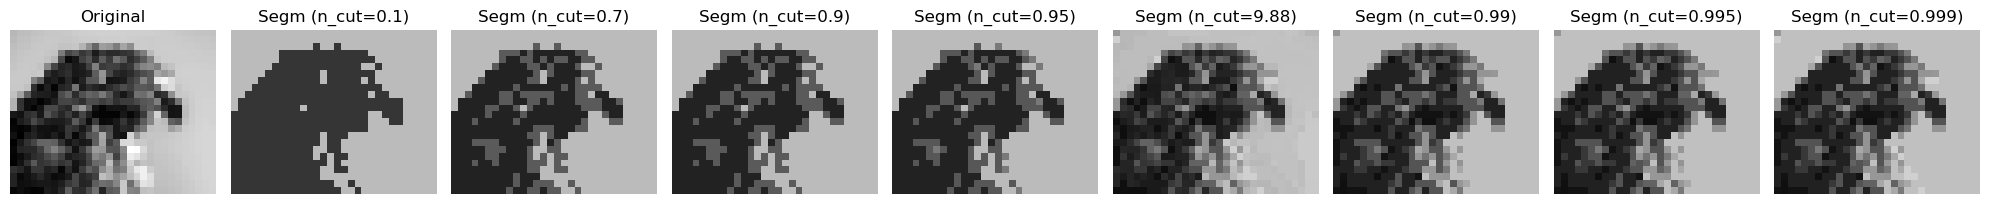

random boje


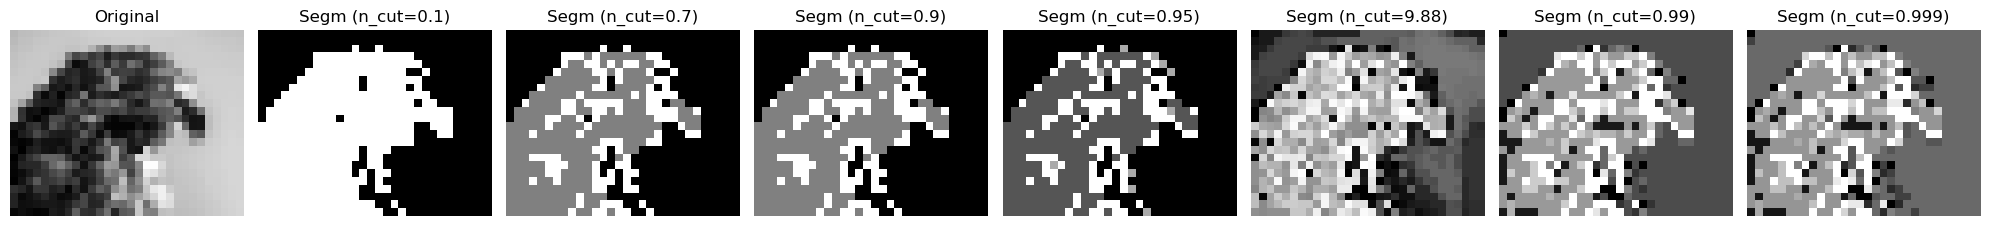

In [8]:
print('custom boje')
visualize_line('images/eagle_30px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999], True)

print('random boje')
visualize_line('images/eagle_30px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99, 0.999], False)

#clusteri ne idu preko 6 

#dvije varijante: 17s


custom boje


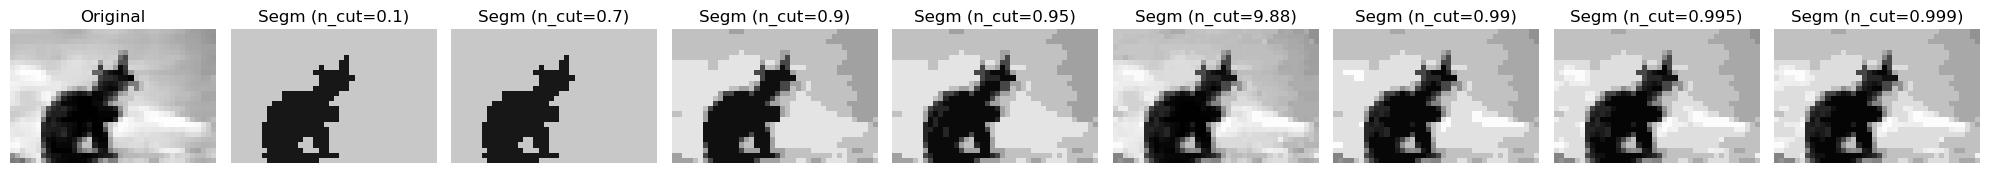

random boje


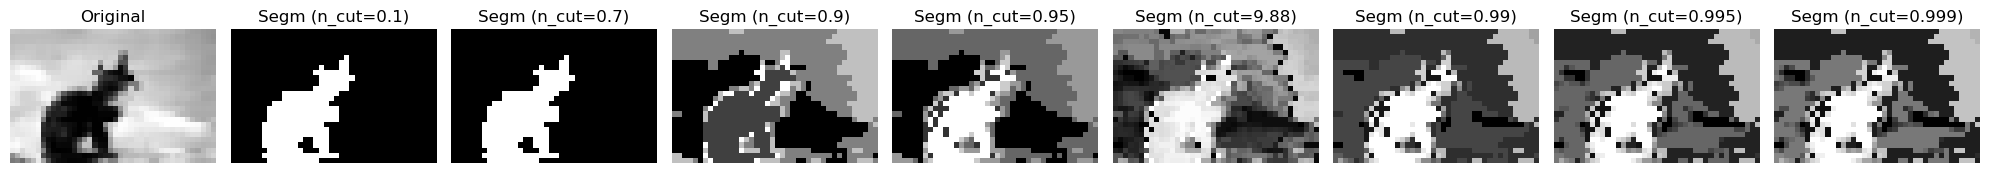

In [9]:
print('custom boje')
visualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)

print('random boje')
visualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False)


custom boje


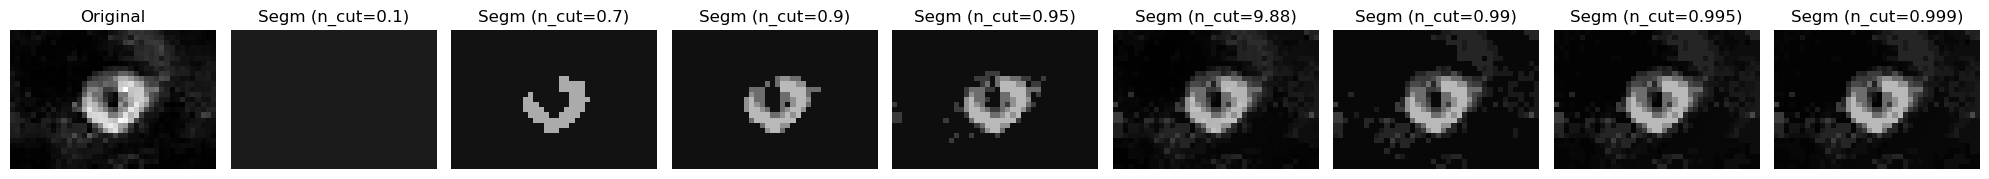

random boje


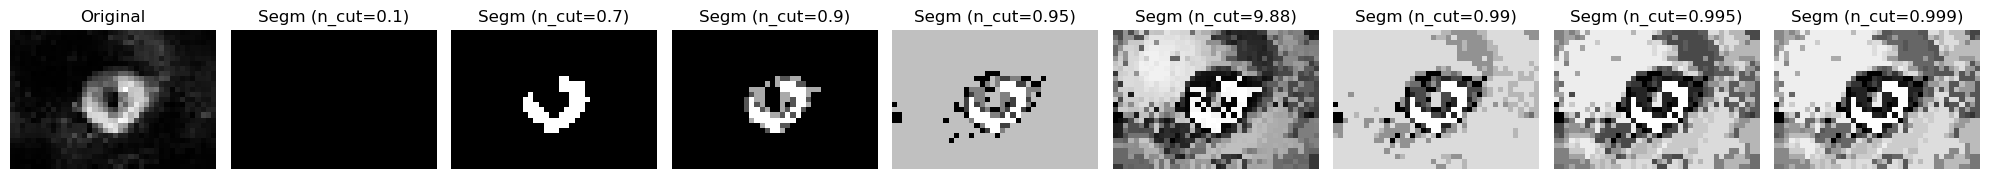

In [10]:
print('custom boje')
visualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)

print('random boje')
visualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False)